# Libs

In [1]:
!pip install pytorch-transformers
!pip install transformers
!pip install nltk
!pip install tweet-preprocessor
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 36.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing 

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import preprocessor as p

from transformers import XLNetTokenizer, XLNetForSequenceClassification
from torch.optim import AdamW

import nltk
from nltk.stem import 	WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

2025-05-22 07:53:00.924619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747900381.364325      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747900381.480002      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

# Config + Dataset + Preprocessing

In [4]:
MAX_LEN = 128

In [5]:
df = pd.read_csv("/kaggle/input/gossipcop-dataset/gossipcop_train.csv")
val_df = pd.read_csv("/kaggle/input/gossipcop-dataset/gossipcop_val.csv")
test_df = pd.read_csv("/kaggle/input/gossipcop-dataset/gossipcop_test.csv")

In [6]:
import re

def preprocess(row):
    text = row['tweet']
    text = p.clean(text)  # clean URL, emoji
    text = re.sub(r'\s+', ' ', text)  
    return text.strip()

In [7]:
df['tweet'] = df.apply(preprocess, axis=1)
val_df['tweet'] = val_df.apply(preprocess, axis=1)
test_df['tweet'] = test_df.apply(preprocess, axis=1)

## 0 if real, 1 if fake

In [8]:
def map_label(row):
  return 0 if row['label']=='real' else 1

In [9]:
df['label_encoded'] = df.apply(lambda x: map_label(x), 1)
val_df['label_encoded'] = val_df.apply(lambda x: map_label(x), 1)
test_df['label_encoded'] = test_df.apply(lambda x: map_label(x), 1)

train_sentences = df.tweet.values
val_sentences = val_df.tweet.values
test_sentences = test_df.tweet.values

train_labels = df.label_encoded.values
val_labels = val_df.label_encoded.values
test_labels = test_df.label_encoded.values

In [10]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False)

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [11]:
def encodeTextWithAttention(sentence,tokenizer,maxlen,padding_type='max_length',attention_mask_flag=True):
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, 
                                         truncation=True, padding=padding_type, 
                                         return_attention_mask=attention_mask_flag)
    return encoded_dict['input_ids'],encoded_dict['attention_mask']

def encodeTextWithoutAttention(sentence,tokenizer,maxlen,padding_type='max_length',attention_mask_flag=False):
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, 
                                         truncation=True, padding=padding_type, 
                                         return_attention_mask=attention_mask_flag)
    return encoded_dict['input_ids']

def getTokenizedTextWithAttentionMask(sentenceList, tokenizer):
    token_ids_list,attention_mask_list = [],[]
    for sentence in sentenceList:
        token_ids,attention_mask = encodeTextWithAttention(sentence,tokenizer,MAX_LEN)
        token_ids_list.append(token_ids)
        attention_mask_list.append(attention_mask)
    return token_ids_list,attention_mask_list

def getTokenizedText(sentenceList, tokenizer):
    token_ids_list = []
    for sentence in sentenceList:
        token_ids = encodeTextWithoutAttention(sentence,tokenizer,MAX_LEN)
        token_ids_list.append(token_ids)
    return token_ids_list

In [12]:
train_token_ids,train_attention_masks = torch.tensor(getTokenizedTextWithAttentionMask(train_sentences,tokenizer))
val_token_ids,val_attention_masks = torch.tensor(getTokenizedTextWithAttentionMask(val_sentences,tokenizer))
test_token_ids,test_attention_masks = torch.tensor(getTokenizedTextWithAttentionMask(test_sentences,tokenizer))

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
test_labels = torch.tensor(test_labels)

# Ready to train

In [13]:
BATCH_SZ = 64

In [14]:
train_data = TensorDataset(train_token_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SZ)

val_data = TensorDataset(val_token_ids, val_attention_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_loader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SZ)

test_data = TensorDataset(test_token_ids, test_attention_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_loader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SZ)

In [15]:
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2).cuda()

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Optimizer
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

In [17]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Training model

In [18]:
# ckp_path = "/kaggle/input/covid/pytorch/default/1/models/XLNet_Covid.ckpt"
# model.load_state_dict(torch.load(ckp_path))

## Train Set + Val Set


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.4681 | Train Acc: 0.7964 | Val Loss: 0.3609 | Val Acc: 0.8512



Epoch:   5%|▌         | 1/20 [07:40<2:25:43, 460.17s/it]

Model saved.
Epoch 2: Train Loss: 0.3665 | Train Acc: 0.8489 | Val Loss: 0.3437 | Val Acc: 0.8597



Epoch:  10%|█         | 2/20 [15:26<2:19:08, 463.79s/it]

Model saved.
Epoch 3: Train Loss: 0.3122 | Train Acc: 0.8748 | Val Loss: 0.3245 | Val Acc: 0.8720



Epoch:  15%|█▌        | 3/20 [23:13<2:11:48, 465.20s/it]

Model saved.



Epoch:  20%|██        | 4/20 [30:59<2:04:06, 465.41s/it]

Epoch 4: Train Loss: 0.2610 | Train Acc: 0.8962 | Val Loss: 0.3616 | Val Acc: 0.8615



Epoch:  25%|██▌       | 5/20 [38:44<1:56:22, 465.48s/it]

Epoch 5: Train Loss: 0.2126 | Train Acc: 0.9162 | Val Loss: 0.3877 | Val Acc: 0.8449


Epoch:  25%|██▌       | 5/20 [46:30<2:19:30, 558.02s/it]

Epoch 6: Train Loss: 0.1699 | Train Acc: 0.9349 | Val Loss: 0.3937 | Val Acc: 0.8597
Early stopping (no improvement after 3 epoch).


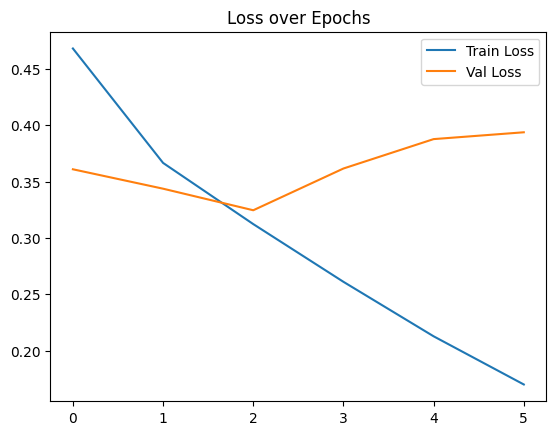

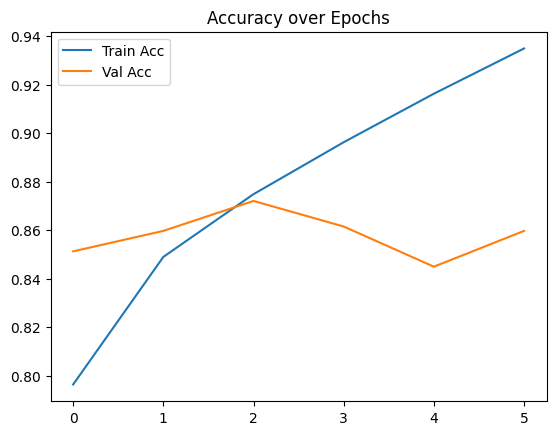

In [19]:
import os
import torch
import matplotlib.pyplot as plt
from tqdm import trange
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Create dir
model_dir = '/kaggle/working/models'
os.makedirs(model_dir, exist_ok=True)

# Train
epochs = 20
patience = 3
early_stop_counter = 0
best_val_acc = 0.00

train_loss, val_loss = [], []
train_acc, val_acc = [], []

for epoch in trange(epochs, desc="Epoch"):
    model.train()
    total_loss = 0
    preds, labels = [], []

    for step, batch in enumerate(train_loader):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attn_mask, lbls = batch

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attn_mask, labels=lbls)
        loss, logits = outputs[:2]

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        labels.extend(lbls.cpu().numpy())

    epoch_train_loss = total_loss / len(train_loader)
    epoch_train_acc = accuracy_score(labels, preds)
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)

    # Validation
    model.eval()
    val_total_loss, val_preds, val_labels = 0, [], []

    with torch.inference_mode():
        for batch in val_loader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attn_mask, lbls = batch

            outputs = model(input_ids, attention_mask=attn_mask, labels=lbls)
            loss, logits = outputs[:2]
            val_total_loss += loss.item()

            val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            val_labels.extend(lbls.cpu().numpy())

    avg_val_loss = val_total_loss / len(val_loader)
    epoch_val_acc = accuracy_score(val_labels, val_preds)
    val_loss.append(avg_val_loss)
    val_acc.append(epoch_val_acc)

    print(f"Epoch {epoch+1}: Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        early_stop_counter = 0
        torch.save(model.state_dict(), os.path.join(model_dir, "XLNet_Gossip_NoCombined.ckpt"))
        print("Model saved.")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping (no improvement after 3 epoch).")
            break

# Plotting
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.show()

plt.plot(train_acc, label="Train Acc")
plt.plot(val_acc, label="Val Acc")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()

# Test Set


Running evaluation on Test Set...


Evaluating: 100%|██████████| 1/1 [00:38<00:00, 38.96s/it]


Evaluation on Test Set:
Test Loss     : 0.3391
Test Accuracy : 0.8627
Precision     : 0.7392
Recall        : 0.6633
F1-score      : 0.6992


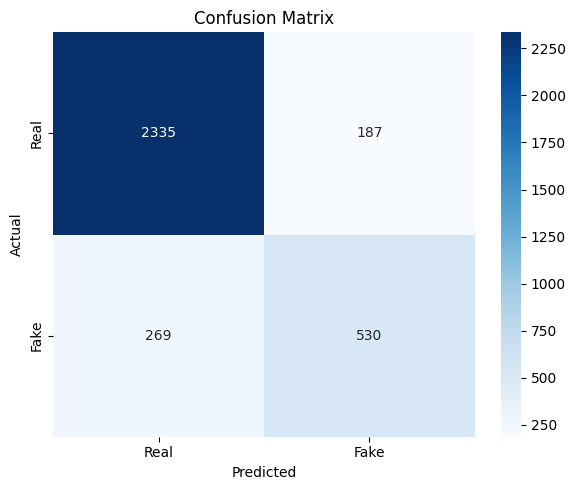

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load best model
model.load_state_dict(torch.load(os.path.join(model_dir, "XLNet_Gossip_NoCombined.ckpt")))
model.eval()

test_loss = 0
test_preds, test_labels = [], []

print("\nRunning evaluation on Test Set...")
with torch.inference_mode():
    for _ in trange(1, desc="Evaluating"):  
        for batch in test_loader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attn_mask, lbls = batch
            outputs = model(input_ids, attention_mask=attn_mask, labels=lbls)
            loss, logits = outputs[:2]
            test_loss += loss.item()
            test_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            test_labels.extend(lbls.cpu().numpy())

# Metrics
avg_test_loss = test_loss / len(test_loader)
test_acc = accuracy_score(test_labels, test_preds)
prec, rec, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='binary')
cm = confusion_matrix(test_labels, test_preds)

print("\nEvaluation on Test Set:")
print(f"Test Loss     : {avg_test_loss:.4f}")
print(f"Test Accuracy : {test_acc:.4f}")
print(f"Precision     : {prec:.4f}")
print(f"Recall        : {rec:.4f}")
print(f"F1-score      : {f1:.4f}")

# Draw confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], 
            yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()